In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ĐỒ ÁN DS KÌ 4 NĂM 2/4.BASELINE&MODELING/silver_data.csv')

In [ ]:
len(df.columns)

32

In [ ]:
df['popularity_score'] = (0.1 * df['comments'] + 0.1 * df['interactions'] ) / (df['time_since_posted'] + 1e-10)

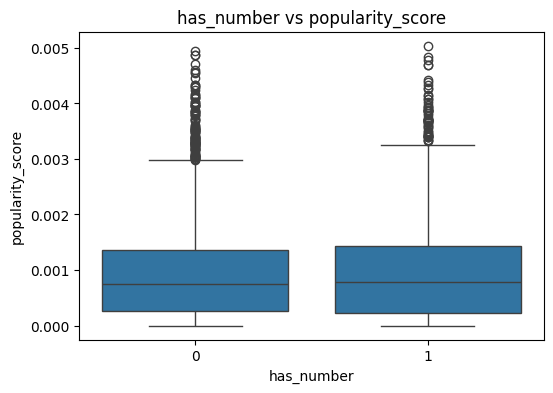

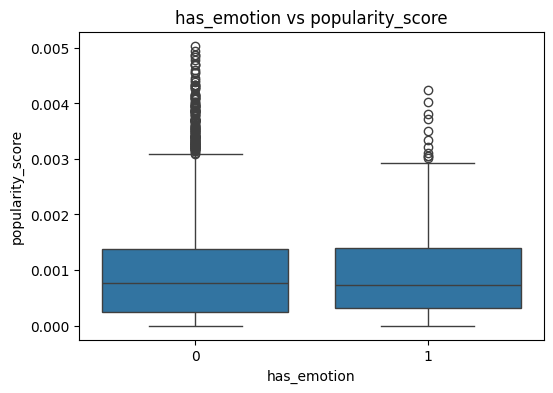

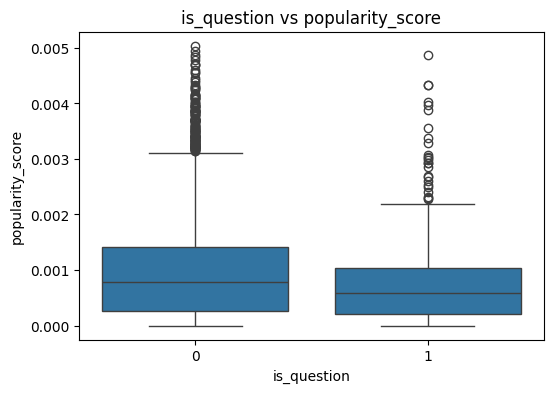

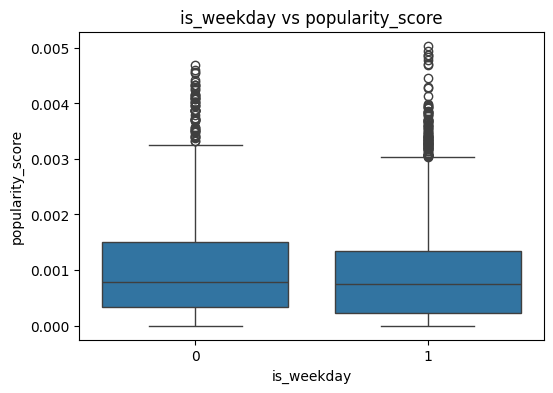

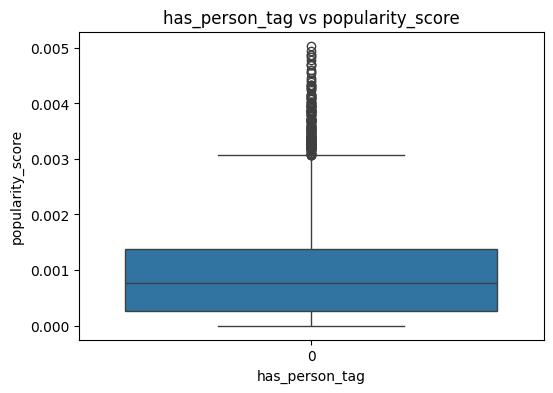

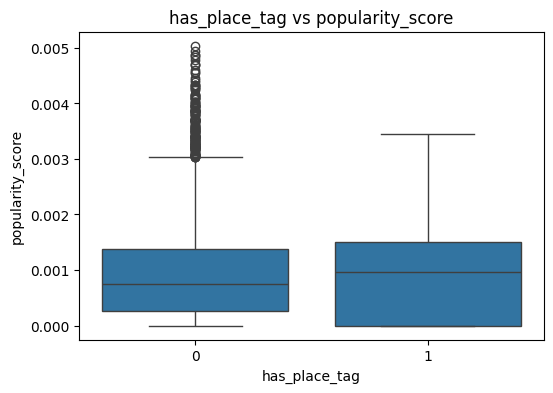

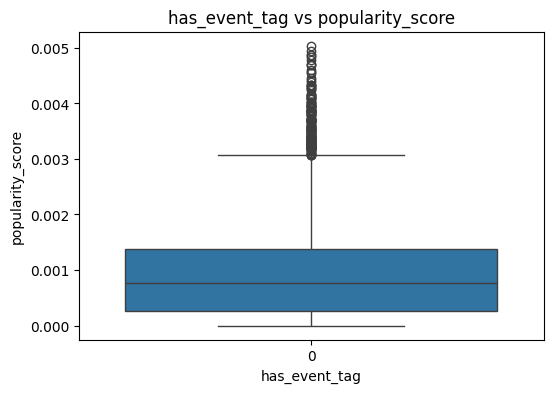

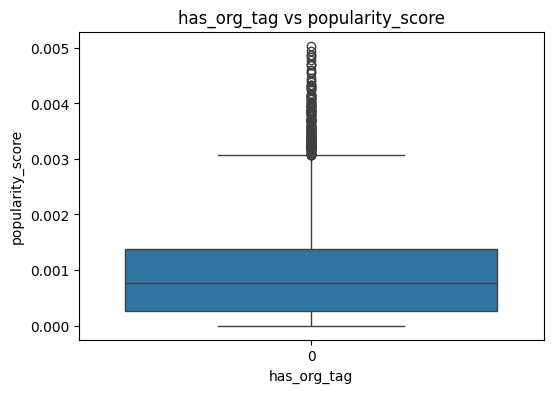

In [ ]:
cat_cols = [
    'has_number', 'has_emotion', 'is_question', 'is_weekday',
    'has_person_tag', 'has_place_tag', 'has_event_tag', 'has_org_tag'
]

for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=col, y='popularity_score', data=df)
    plt.title(f'{col} vs popularity_score')
    plt.show()

In [ ]:
num_cols = [
     'wordcount', 'comments', 'interactions', 'images',
      'videos', 'time_since_posted', 'title_length', 'title_score',
       'sentiment_score', 'positive', 'negative', 'neutral',
        'posted_hour', 'tag_count', 'popularity_score',
        'tag_score', 'tag_diversity','popular_tag_score'
]

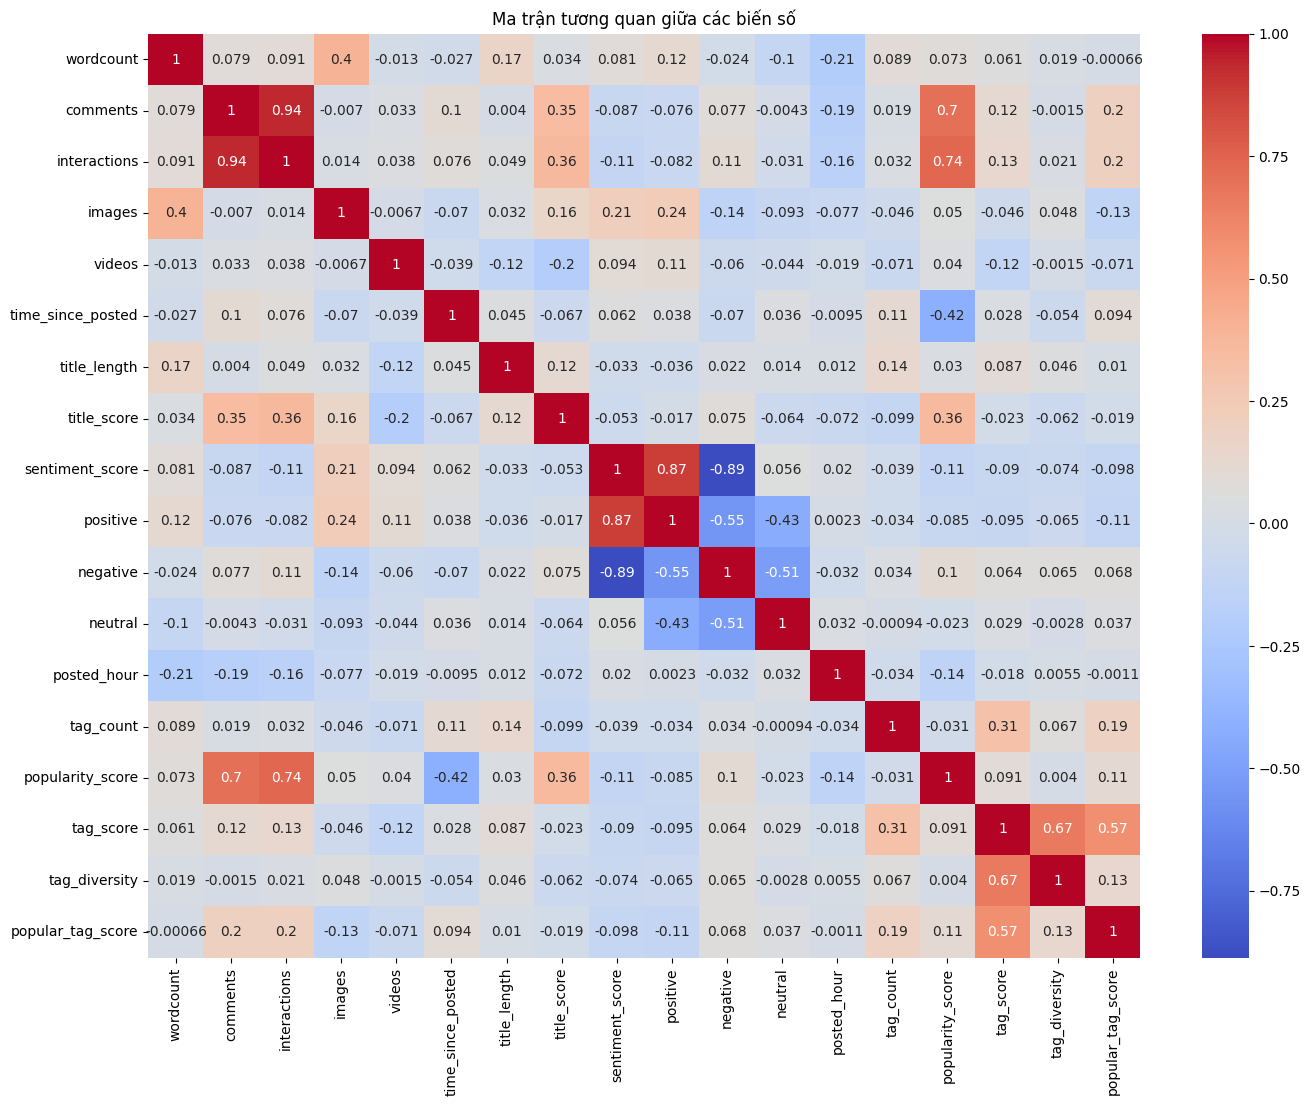

In [ ]:
plt.figure(figsize=(16, 12))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Ma trận tương quan giữa các biến số')
plt.show()

In [ ]:
# Loại bỏ các cột kiểu object
df = df.drop(columns=['title', 'date'])

In [ ]:
# Hàm chuẩn hóa tag (giả định bạn muốn loại bỏ khoảng trắng và chuyển thành chữ thường)
def normalize_tag(tag):
    return tag.strip()

# Hàm parse tags từ chuỗi thành danh sách
def parse_tags(tags):
    if pd.isna(tags):
        return []
    if isinstance(tags, str):
        return [normalize_tag(tag.lower()) for tag in tags.split(',')]
    return tags

# Áp dụng parse_tags để chuyển cột tags thành danh sách
tags_list = df['tags'].apply(parse_tags)

In [ ]:
#  Đếm tần suất các tag và lọc tag phổ biến
min_count = 5  # Đặt ngưỡng tối thiểu (có thể điều chỉnh)
tag_counts = Counter(tag for tags in tags_list for tag in tags)
frequent_tags = {tag for tag, count in tag_counts.items() if count >= min_count}

In [ ]:
# Lọc chỉ giữ lại các tag phổ biến
filtered_tags_list = [[tag for tag in tags if tag in frequent_tags] for tags in tags_list]

# Thêm cột filtered_tags vào df
df['filtered_tags'] = filtered_tags_list

In [ ]:
y = df['popularity_score']
X = df.drop(columns=['popularity_score','comments', 'interactions', 'tags'])

In [ ]:
len(X.columns)

26

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Lưu lại các cột không cần chuẩn hóa
X_train_tags = X_train[[ 'filtered_tags']]
X_dev_tags = X_dev[[ 'filtered_tags']]
X_test_tags = X_test[[ 'filtered_tags']]

# Lấy các cột số để chuẩn hóa
X_train_num = X_train.drop(columns=['filtered_tags'])
X_dev_num = X_dev.drop(columns=[ 'filtered_tags'])
X_test_num = X_test.drop(columns=[ 'filtered_tags'])

# Chuẩn hóa
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), columns=X_train_num.columns)
X_dev_scaled = pd.DataFrame(scaler.transform(X_dev_num), columns=X_dev_num.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)


In [ ]:
print(f"Train set: {X_train.shape}, Dev set: {X_dev.shape}, Test set: {X_test.shape}")

Train set: (4248, 26), Dev set: (531, 26), Test set: (531, 26)


In [ ]:
# Khởi tạo PCA với 20 thành phần chính
pca = PCA(n_components=20)

# Fit và transform trên tập train (đã chuẩn hóa)
X_train_pca = pca.fit_transform(X_train_scaled)

# Transform trên tập dev và test
X_dev_pca = pca.transform(X_dev_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
print(pca.explained_variance_ratio_)  # Tỷ lệ phương sai của từng thành phần
print(sum(pca.explained_variance_ratio_))  # Tổng phương sai được giữ lại

[1.54440063e-01 1.15361597e-01 8.91634910e-02 7.58693957e-02
 6.46797994e-02 6.00887844e-02 5.24513637e-02 4.78145670e-02
 4.59413886e-02 4.51821289e-02 4.12696064e-02 4.11653834e-02
 3.63629977e-02 3.45966429e-02 3.21065225e-02 2.48477172e-02
 2.23021065e-02 1.50160052e-02 1.34043883e-03 2.14325976e-16]
1.0


Sử dụng BoW

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

# Tạo BoW cho từng tập train/dev/test từ cột 'filtered_tags'
mlb = MultiLabelBinarizer()

# X_train_tags là DataFrame chỉ chứa 2 cột ['tags', 'filtered_tags']
train_tag_lists = X_train_tags['filtered_tags']
dev_tag_lists   = X_dev_tags['filtered_tags']
test_tag_lists  = X_test_tags['filtered_tags']

# Fit trên train rồi transform cả 3
X_train_tags_bow = mlb.fit_transform(train_tag_lists)
X_dev_tags_bow   = mlb.transform(dev_tag_lists)
X_test_tags_bow  = mlb.transform(test_tag_lists)

print(f"Số đặc trưng BoW: {len(mlb.classes_)}")  # kiểm tra

Số đặc trưng BoW: 548


In [ ]:
X_train_combined = np.hstack((X_train_pca, X_train_tags_bow))
X_dev_combined   = np.hstack((X_dev_pca,   X_dev_tags_bow))
X_test_combined  = np.hstack((X_test_pca,  X_test_tags_bow))

print("Kích thước cuối cùng của X_train:", X_train_combined.shape)

Kích thước cuối cùng của X_train: (4248, 568)


## Sử dụng kfold kết hợp train-dev-test, áp dụng GridSearchCV để tim tham số tốt nhất ##

In [ ]:
from xgboost import XGBRegressor

# Định nghĩa K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV cho từng mô hình
models = {
    'XGBoost Regressor': {
        'estimator': XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    },
    'Ridge Regression': {
        'estimator': Ridge(),
        'param_grid': {'alpha': [0.01, 0.1, 1, 10, 100]}
    },
    'Random Forest Regressor': {
        'estimator': RandomForestRegressor(random_state=42),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [5, 7, 10],
            'min_samples_split': [2, 5]
        }
    }
}

# Lưu trữ mô hình tốt nhất và kết quả
best_models = {}
results = {}

for model_name, config in models.items():
    print(f"\n--- Huấn luyện {model_name} ---")

    # Khởi tạo GridSearchCV
    grid = GridSearchCV(
        estimator=config['estimator'],
        param_grid=config['param_grid'],
        scoring='neg_root_mean_squared_error',
        cv=kf,
        verbose=1,
        n_jobs=-1
    )

    # Fit GridSearchCV
    grid.fit(X_train_combined, y_train)

    # Lấy mô hình tốt nhất
    best_model = grid.best_estimator_
    best_models[model_name] = best_model

    # In siêu tham số tốt nhất
    print(f"Best parameters ({model_name}): {grid.best_params_}")
    print(f"Best CV score (neg RMSE): {grid.best_score_:.4f}")

    # Dự đoán trên dev
    y_dev_pred = best_model.predict(X_dev_combined)

    # Tính RMSE và R²
    dev_rmse = mean_squared_error(y_dev, y_dev_pred)**0.5
    dev_r2 = r2_score(y_dev, y_dev_pred)

    # Lưu kết quả
    results[model_name] = {
        'dev_rmse': dev_rmse,
        'dev_r2': dev_r2,

    }

    # In kết quả
    print(f"\n{model_name} (best parameters)")

    # Nếu muốn hiểu mô hình hoạt động như thế nào thì chạy luôn cái này
    # if model_name in ['Ridge Regression']:
    #     print("Hệ số (cho các thành phần chính):")
    #     for i, coef in enumerate(best_model.coef_):
    #         print(f"  PC{i+1}: {coef:.4f}")
    # else:  # Random Forest hoặc XGBoost
    #     print("Độ quan trọng của các thành phần chính:")
    #     for i, importance in enumerate(best_model.feature_importances_):
    #         print(f"  PC{i+1}: {importance:.4f}")

    print("Dev set:")
    print(f"RMSE: {dev_rmse:.4f}")
    print(f"R²: {dev_r2:.4f}")



--- Huấn luyện XGBoost Regressor ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters (XGBoost Regressor): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best CV score (neg RMSE): -0.0007

XGBoost Regressor (best parameters)
Dev set:
RMSE: 0.0007
R²: 0.3623

--- Huấn luyện Ridge Regression ---
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters (Ridge Regression): {'alpha': 10}
Best CV score (neg RMSE): -0.0007

Ridge Regression (best parameters)
Dev set:
RMSE: 0.0007
R²: 0.3746

--- Huấn luyện Random Forest Regressor ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters (Random Forest Regressor): {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best CV score (neg RMSE): -0.0007

Random Forest Regressor (best parameters)
Dev set:
RMSE: 0.0007
R²: 0.3326


In [ ]:
# Dùng mô hình tốt nhất từ GridSearch
xgb_model = best_models['XGBoost Regressor']
xgb_model.fit(X_train_combined, y_train)

# Dự đoán
y_pred_xgb = xgb_model.predict(X_test_combined)

# Đánh giá
print("XGBoost - RMSE:", mean_squared_error(y_test, y_pred_xgb)**0.5)
print("XGBoost - R2 score:", r2_score(y_test, y_pred_xgb))


XGBoost - RMSE: 0.0006699202781888497
XGBoost - R2 score: 0.4619729150943681


In [ ]:
# Dùng mô hình tốt nhất từ GridSearch
rf_model = best_models['Random Forest Regressor']
rf_model.fit(X_train_combined, y_train)

# Dự đoán
y_pred_rf = rf_model.predict(X_test_combined)

# Đánh giá
print("Random Forest - RMSE:", mean_squared_error(y_test, y_pred_rf)**0.5)
print("Random Forest - R2 score:", r2_score(y_test, y_pred_rf))


Random Forest - RMSE: 0.0007045890798058824
Random Forest - R2 score: 0.40484551991448225


In [ ]:
# Dùng mô hình tốt nhất từ GridSearch
rr_model = best_models['Ridge Regression']
rr_model.fit(X_train_combined, y_train)

# Dự đoán
y_pred_rr = rr_model.predict(X_test_combined)

# Đánh giá
print("Ridge Regression - RMSE:", mean_squared_error(y_test, y_pred_rr)**0.5)
print("Ridge Regression - R2 score:", r2_score(y_test, y_pred_rr))

Ridge Regression - RMSE: 0.0006582799826867381
Ridge Regression - R2 score: 0.4805076107004066


In [ ]:
import joblib
joblib.dump(best_models['XGBoost Regressor'], 'best_xgboost_model.pkl')
print("Mô hình XGBoost đã được lưu tại 'best_xgboost_model.pkl'")


Mô hình XGBoost đã được lưu tại 'best_xgboost_model.pkl'


In [ ]:
from google.colab import files
files.download('best_xgboost_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp best_xgboost_model.pkl /content/drive/MyDrive/ĐỒ ÁN DS KÌ 4 NĂM 2/4.BASELINE&MODELING
print("File đã được sao chép lên Google Drive ở MyDrive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/bin/bash: line 1: MODELING: command not found
cp: target '2/4.BASELINE' is not a directory
File đã được sao chép lên Google Drive ở MyDrive


### KIỂM ĐỊNH THỐNG KÊ


=== KIỂM ĐỊNH TÍNH CHUẨN CỦA PHẦN DƯ ===

1.1. Shapiro-Wilk test:
Thống kê: 0.8491
p-value: 0.0000
Kết luận: Phần dư không tuân theo phân phối chuẩn

1.2. Jarque-Bera test:
Thống kê: 1454.6494
p-value: 0.0000
Kết luận: Phần dư không tuân theo phân phối chuẩn

=== KIỂM ĐỊNH TÍNH ĐỘC LẬP CỦA PHẦN DƯ ===

2.1. Durbin-Watson test:
Thống kê: 2.1225
Kết luận: Phần dư độc lập

2.2. Ljung-Box test:
Thống kê cho các lag [5, 10, 15]: ['4.8205', '9.6813', '11.9374']
p-value cho các lag [5, 10, 15]: ['0.4382', '0.4689', '0.6838']
Kết luận: Không có tự tương quan

=== KIỂM ĐỊNH TÍNH ĐỒNG NHẤT CỦA PHƯƠNG SAI ===

3.1. Breusch-Pagan test: Không thể thực hiện kiểm định

3.2. Goldfeld-Quandt test:
Thống kê: 0.6493
p-value: 0.9795
Kết luận: Phương sai đồng nhất

=== KIỂM ĐỊNH ĐA CỘNG TUYẾN (VIF) ===
Không thể tính toán VIF: 'numpy.ndarray' object has no attribute 'columns'


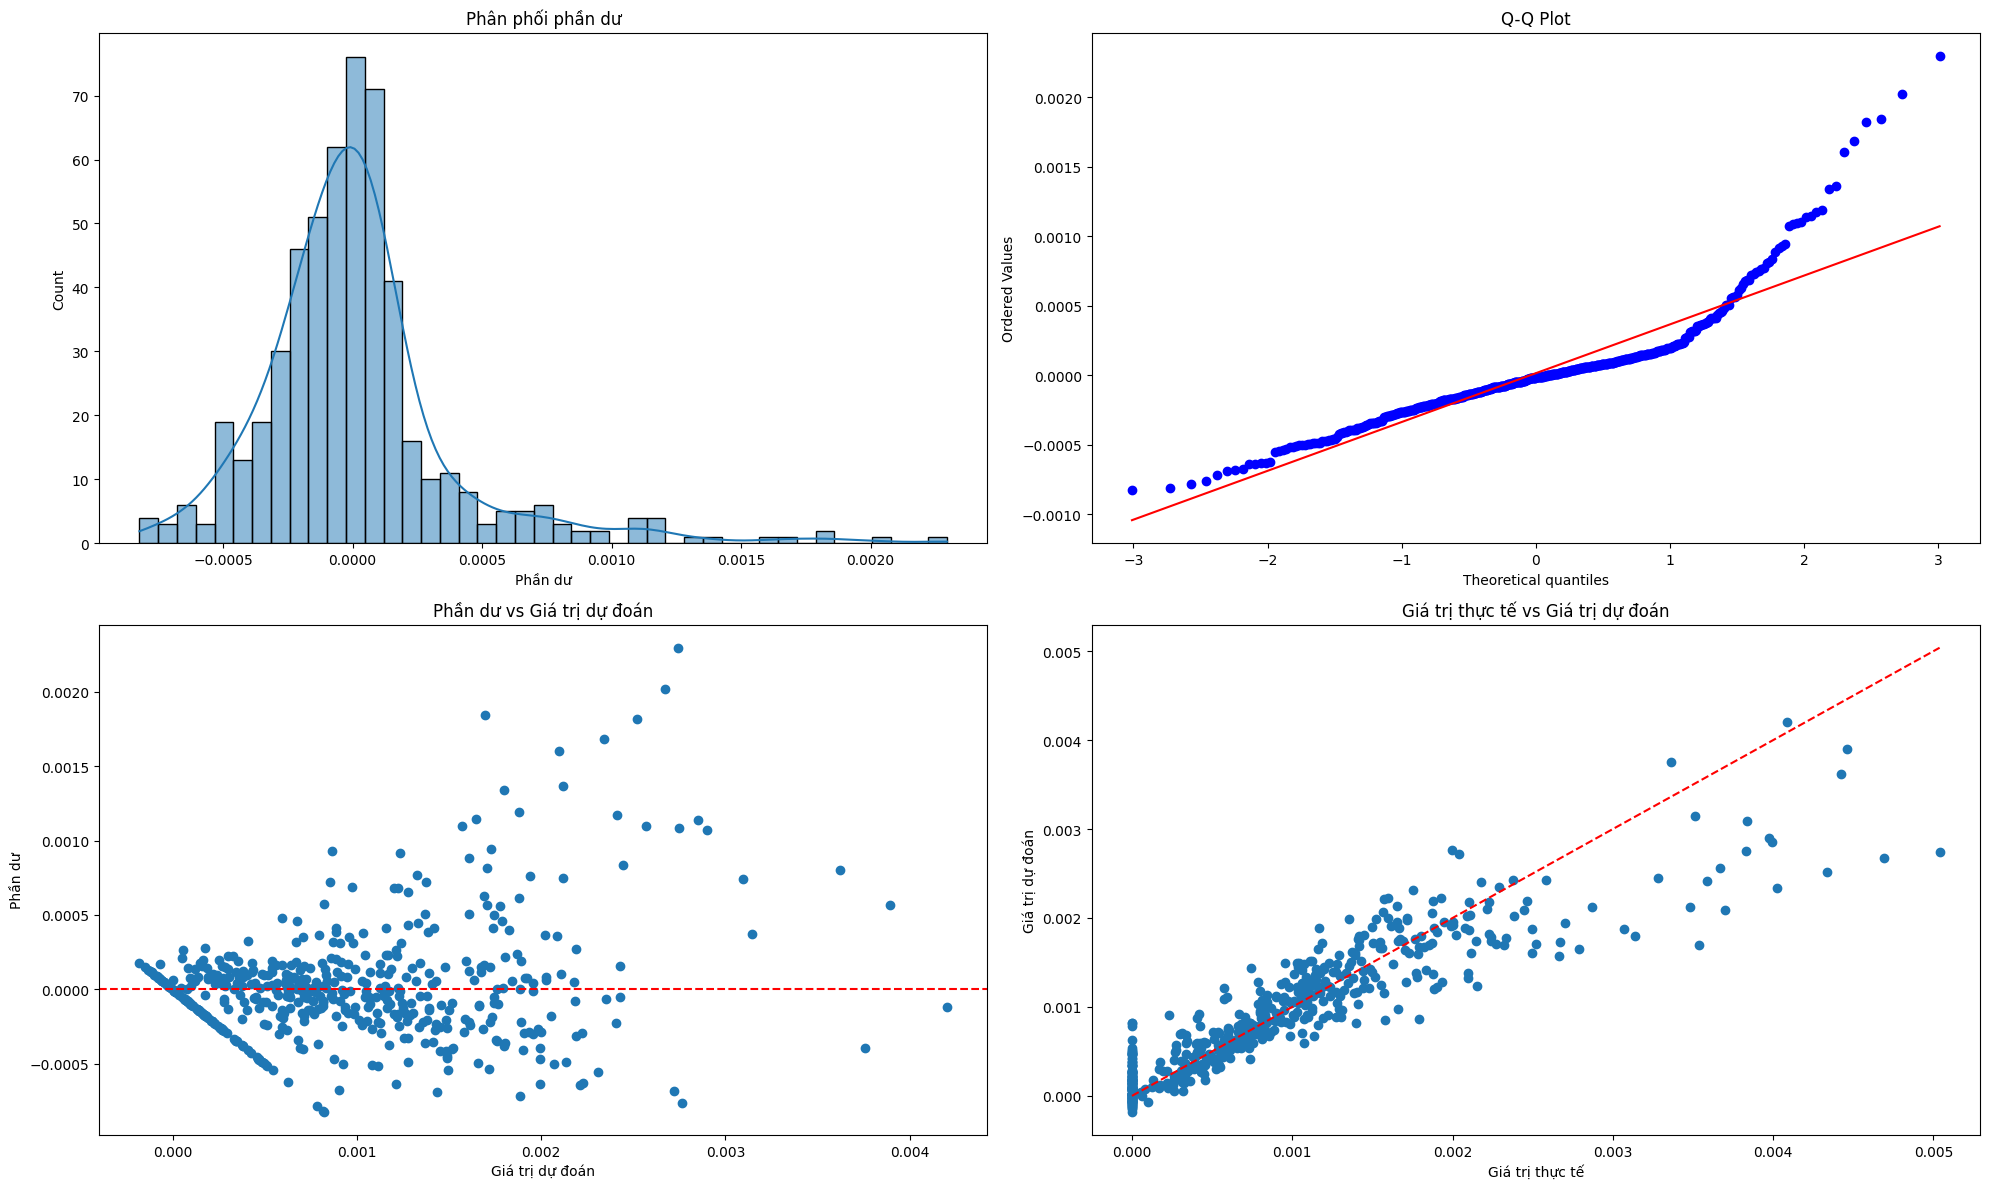


=== CÁC METRIC ĐÁNH GIÁ MÔ HÌNH ===
RMSE: 0.0004
R²: 0.8267
MAE: 0.0002
MAPE: inf%
Giải thích phương sai: 0.6611


In [ ]:
# Thêm các import cần thiết
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_goldfeldquandt

# Tính toán phần dư
residuals = y_test - y_pred

# 1. Kiểm định tính chuẩn của phần dư
print("\n=== KIỂM ĐỊNH TÍNH CHUẨN CỦA PHẦN DƯ ===")

# 1.1. Shapiro-Wilk test
shapiro_test = stats.shapiro(residuals)
print("\n1.1. Shapiro-Wilk test:")
print(f"Thống kê: {shapiro_test[0]:.4f}")
print(f"p-value: {shapiro_test[1]:.4f}")
print(f"Kết luận: {'Phần dư tuân theo phân phối chuẩn' if shapiro_test[1] > 0.05 else 'Phần dư không tuân theo phân phối chuẩn'}")

# 1.2. Jarque-Bera test
jb_test = jarque_bera(residuals)
print("\n1.2. Jarque-Bera test:")
print(f"Thống kê: {jb_test[0]:.4f}")
print(f"p-value: {jb_test[1]:.4f}")
print(f"Kết luận: {'Phần dư tuân theo phân phối chuẩn' if jb_test[1] > 0.05 else 'Phần dư không tuân theo phân phối chuẩn'}")

# 2. Kiểm định tính độc lập của phần dư
print("\n=== KIỂM ĐỊNH TÍNH ĐỘC LẬP CỦA PHẦN DƯ ===")

# 2.1. Durbin-Watson test
dw_stat = durbin_watson(residuals)
print("\n2.1. Durbin-Watson test:")
print(f"Thống kê: {dw_stat:.4f}")
print(f"Kết luận: {'Phần dư độc lập' if 1.5 < dw_stat < 2.5 else 'Phần dư có tương quan'}")

# 2.2. Ljung-Box test
lb_test = acorr_ljungbox(residuals, lags=[5, 10, 15], return_df=True)
print("\n2.2. Ljung-Box test:")
print("Thống kê cho các lag [5, 10, 15]:", [f"{stat:.4f}" for stat in lb_test['lb_stat']])
print("p-value cho các lag [5, 10, 15]:", [f"{pval:.4f}" for pval in lb_test['lb_pvalue']])
print(f"Kết luận: {'Không có tự tương quan' if all(p > 0.05 for p in lb_test['lb_pvalue']) else 'Có tự tương quan'}")

# 3. Kiểm định tính đồng nhất của phương sai
print("\n=== KIỂM ĐỊNH TÍNH ĐỒNG NHẤT CỦA PHƯƠNG SAI ===")

# 3.1. Breusch-Pagan test
try:
    bp_test = het_breuschpagan(residuals, X_test_combined)
    print("\n3.1. Breusch-Pagan test:")
    print(f"Thống kê: {bp_test[0]:.4f}")
    print(f"p-value: {bp_test[1]:.4f}")
    print(f"Kết luận: {'Phương sai đồng nhất' if bp_test[1] > 0.05 else 'Phương sai không đồng nhất'}")
except:
    print("\n3.1. Breusch-Pagan test: Không thể thực hiện kiểm định")

# 3.2. Goldfeld-Quandt test
try:
    gq_test = het_goldfeldquandt(residuals, X_test_combined)
    print("\n3.2. Goldfeld-Quandt test:")
    print(f"Thống kê: {gq_test[0]:.4f}")
    print(f"p-value: {gq_test[1]:.4f}")
    print(f"Kết luận: {'Phương sai đồng nhất' if gq_test[1] > 0.05 else 'Phương sai không đồng nhất'}")
except:
    print("\n3.2. Goldfeld-Quandt test: Không thể thực hiện kiểm định")

# 4. Kiểm định đa cộng tuyến (VIF)
# Sửa lại phần code kiểm định VIF
print("\n=== KIỂM ĐỊNH ĐA CỘNG TUYẾN (VIF) ===")
try:
    # Kiểm tra xem X_test_combined có dữ liệu không
    if X_test_combined.shape[1] > 0:
        vif_data = pd.DataFrame()
        vif_data["Biến"] = X_test_combined.columns
        vif_data["VIF"] = [variance_inflation_factor(X_test_combined.values, i)
                          for i in range(X_test_combined.shape[1])]

        print("\nGiá trị VIF của các biến:")
        print(vif_data.to_string(index=False))

        # Kiểm tra đa cộng tuyến
        high_vif = vif_data[vif_data['VIF'] > 5]
        if len(high_vif) > 0:
            print("\nCó dấu hiệu đa cộng tuyến (VIF > 5) ở các biến sau:")
            print(high_vif.to_string(index=False))
        else:
            print("\nKhông có dấu hiệu đa cộng tuyến nghiêm trọng (tất cả VIF <= 5)")
    else:
        print("Không thể tính VIF: Dữ liệu đầu vào trống")
except Exception as e:
    print(f"Không thể tính toán VIF: {str(e)}")

# Sửa lại phần vẽ biểu đồ (bỏ phần VIF plot)
plt.figure(figsize=(20, 12))  # Giảm kích thước figure vì bỏ 1 subplot

# 5.1. Phân phối phần dư
plt.subplot(2, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Phân phối phần dư')
plt.xlabel('Phần dư')

# 5.2. Q-Q plot
plt.subplot(2, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')

# 5.3. Scatter plot phần dư vs giá trị dự đoán
plt.subplot(2, 2, 3)
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Phần dư vs Giá trị dự đoán')
plt.xlabel('Giá trị dự đoán')
plt.ylabel('Phần dư')

# 5.4. Scatter plot giá trị thực tế vs giá trị dự đoán
plt.subplot(2, 2, 4)
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Giá trị thực tế vs Giá trị dự đoán')
plt.xlabel('Giá trị thực tế')
plt.ylabel('Giá trị dự đoán')

plt.tight_layout()
plt.show()

# 6. In thêm các metric đánh giá
print("\n=== CÁC METRIC ĐÁNH GIÁ MÔ HÌNH ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {np.mean(np.abs(residuals)):.4f}")
print(f"MAPE: {np.mean(np.abs(residuals / y_test)) * 100:.2f}%")
print(f"Giải thích phương sai: {np.var(y_pred) / np.var(y_test):.4f}")

#### BÁO CÁO PHÂN TÍCH KIỂM ĐỊNH THỐNG KÊ MÔ HÌNH HỒI QUY

##### 1. Kiểm định tính chuẩn của phần dư
- Shapiro-Wilk test:
- Thống kê kiểm định: 0.8491
- p-value: 0.0000
- Kết luận: Phần dư không tuân theo phân phối chuẩn (p-value < 0.05).
- Jarque-Bera test:
- Thống kê kiểm định: 1454.6494
- p-value: 0.0000
- Kết luận: Phần dư không tuân theo phân phối chuẩn (p-value < 0.05).
- Nhận xét: Kết quả kiểm định và biểu đồ histogram, Q-Q plot cho thấy phần dư của mô hình không tuân theo phân phối chuẩn. Điều này thường gặp ở các mô hình phi tuyến tính như XGBoost. Tuy nhiên, nếu mục tiêu là dự báo thì đây không phải là vấn đề quá nghiêm trọng.
##### 2. Kiểm định tính độc lập của phần dư
- Durbin-Watson test:
- Thống kê kiểm định: 2.1225
- Kết luận: Phần dư độc lập (giá trị nằm trong khoảng 1.5 – 2.5).
- Ljung-Box test:
- Thống kê cho các lag [5, 10, 15]: [4.8205, 9.6813, 11.9374]
- p-value cho các lag [5, 10, 15]: [0.4382, 0.4689, 0.6838]
- Kết luận: Không có tự tương quan trong phần dư (p-value > 0.05 cho mọi lag).
- Nhận xét:
Phần dư của mô hình là độc lập, không có hiện tượng tự tương quan. Đây là một dấu hiệu tốt, cho thấy mô hình không bỏ sót các yếu tố tuần tự hoặc chuỗi thời gian.
##### 3. Kiểm định tính đồng nhất của phương sai (Homoscedasticity)
- Breusch-Pagan test: Không thể thực hiện kiểm định do dữ liệu đầu vào không phù hợp.
- Goldfeld-Quandt test:
- Thống kê kiểm định: 0.6493
- p-value: 0.9795
- Kết luận: Phương sai phần dư đồng nhất (p-value > 0.05).
- Nhận xét: Phần dư có phương sai đồng nhất, không có hiện tượng phương sai thay đổi theo giá trị dự đoán. Điều này giúp đảm bảo các ước lượng của mô hình là hiệu quả.
##### 4. Kiểm định đa cộng tuyến (VIF)
- Kết quả: Không thể tính toán VIF do dữ liệu đầu vào là numpy array, không phải DataFrame.
- Nhận xét: Đa cộng tuyến chủ yếu ảnh hưởng đến các mô hình tuyến tính. Với XGBoost, ảnh hưởng này không lớn. Tuy nhiên, nếu muốn kiểm tra ý nghĩa từng biến đầu vào, nên chuyển dữ liệu về dạng DataFrame để kiểm tra lại.
##### 5. Đánh giá tổng quan mô hình
- RMSE: 0.0004
- R²: 0.8267
- MAE: 0.0002
- MAPE: inf% (do có giá trị thực tế bằng 0)
- Giải thích phương sai: 0.6611
- Nhận xét: Mô hình dự báo khá tốt với sai số nhỏ và R² cao (~82.7%). Tuy nhiên, cần kiểm tra lại dữ liệu đầu ra để tránh giá trị 0 gây lỗi khi tính MAPE.
##### 6. Phân tích biểu đồ
- Phân phối phần dư: Phần dư phân bố lệch phải, không chuẩn hóa.
- Q-Q plot: Các điểm lệch khỏi đường chéo, đặc biệt ở hai đầu, xác nhận phần dư không chuẩn.
Scatter plot phần dư vs giá trị dự đoán: Phần dư phân tán đều quanh trục 0, không có hình phễu rõ rệt.
- Scatter plot giá trị thực tế vs giá trị dự đoán: Các điểm phân bố khá sát đường chéo, cho thấy mô hình dự báo tốt, tuy nhiên ở các giá trị lớn mô hình có xu hướng dự báo thấp hơn thực tế.
##### 7. Kết luận & Đề xuất
- Mô hình XGBoost dự báo tốt, phần dư độc lập và có phương sai đồng nhất.
- Phần dư không tuân theo phân phối chuẩn, điều này không ảnh hưởng nhiều đến mục tiêu dự báo.
Nên kiểm tra lại dữ liệu đầu ra để tránh giá trị 0 khi tính MAPE.
- Nếu muốn kiểm tra đa cộng tuyến, hãy chuyển dữ liệu về dạng DataFrame với tên cột.
Có thể thử thêm các đặc trưng mới hoặc các mô hình khác để cải thiện kết quả.

In [ ]:
from scipy.stats import ttest_1samp

# Tính phần dư
residuals = y_test - y_pred

# Kiểm định t-test một mẫu (so sánh trung bình phần dư với 0)
t_stat, p_value = ttest_1samp(residuals, 0)

print("=== Kiểm định t-test một mẫu cho phần dư ===")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Trung bình phần dư khác 0 có ý nghĩa thống kê.")
else:
    print("Trung bình phần dư không khác 0 có ý nghĩa thống kê.")

=== Kiểm định t-test một mẫu cho phần dư ===
t-statistic: 0.8247
p-value: 0.4099
Trung bình phần dư không khác 0 có ý nghĩa thống kê.
